In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df = pd.read_csv('run_res.txt')
results = df.to_numpy()

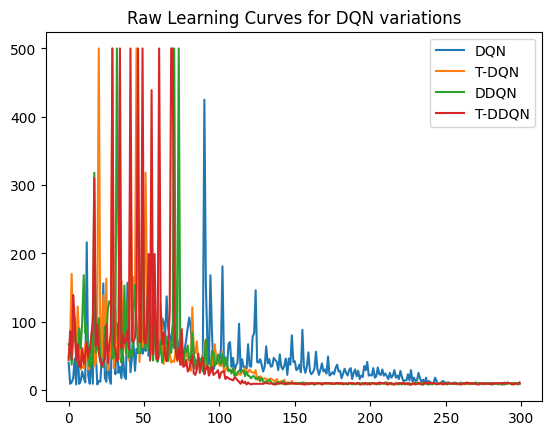

In [13]:

dqn, t_dqn, ddqn, t_ddqn = results[:, 0], results[:, 1], results[:, 2], results[:, 3]
arrs = dqn, t_dqn, ddqn, t_ddqn

plt.title("Raw Learning Curves for DQN variations")
plt.plot(dqn, label='DQN'), plt.plot(t_dqn, label='T-DQN'), plt.plot(ddqn, label='DDQN'), plt.plot(t_ddqn, label='T-DDQN')
plt.legend()
# plt.ylim(7, 15)
plt.show()

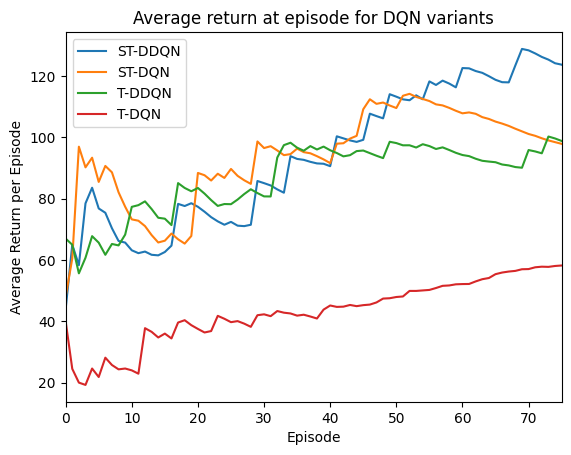

In [14]:
smoothed_dqn, smoothed_t_dqn, smoothed_ddqn, smoothed_t_ddqn = np.zeros_like(t_ddqn), np.zeros_like(t_ddqn), np.zeros_like(t_ddqn), np.zeros_like(t_ddqn)

# n-step moving average plotting
# period = 15
# for i in range(period, smoothed_t_ddqn.shape[0] - period):
#     smoothed_t_ddqn[i], smoothed_t_dqn[i] = np.mean(t_ddqn[i-period:i+period-1]), np.mean(t_dqn[i-period:i+period-1])
#     smoothed_dqn[i], smoothed_ddqn[i] = np.mean(dqn[i-period:i+period-1]), np.mean(ddqn[i-period:i+period-1])
# plt.plot(smoothed_t_ddqn, label='Smooth T-DDQN')
# plt.plot(smoothed_ddqn, label='Smooth DDQN')
# plt.plot(smoothed_t_dqn, label='Smooth T-DQN')
# plt.plot(smoothed_dqn, label='Smooth DQN')

# cumulative averaging/summing
factor = np.array(list(range(1, smoothed_t_ddqn.shape[0] + 1)))
# factor = np.ones_like(smoothed_t_ddqn)
plt.title("Average return at episode for DQN variants")
plt.xlabel("Episode")
plt.ylabel("Average Return per Episode")
plt.plot(np.cumsum(t_ddqn)/factor, label='ST-DDQN')
plt.plot(np.cumsum(t_dqn)/factor, label='ST-DQN')
plt.plot(np.cumsum(ddqn)/factor, label='T-DDQN')
plt.plot(np.cumsum(dqn)/factor, label='T-DQN')
plt.plot()
plt.legend()
plt.xlim(0, 75)
plt.show()

In [9]:
from gym.envs import make as gym_env_make

py_env = gym_env_make('CarRacing-v2', continuous=False)

time_step = py_env.reset()

In [10]:
# step the environment forward, so we can see the normal view
for i in range(25):
    time_step = py_env.step(0)

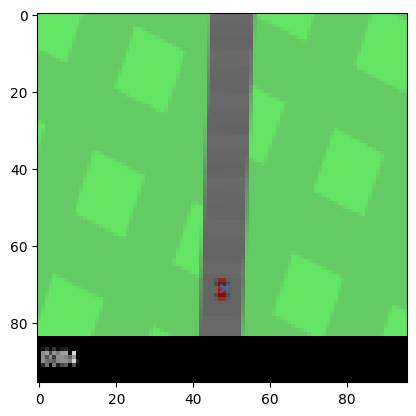

In [11]:

obs = time_step[0]
plt.imshow(obs, interpolation='nearest')
plt.scatter((48,), (71,), marker='x')

# plt.scatter((30,), (75,), marker='x')
# plt.scatter((20, ), (60, ), marker='x')
# plt.scatter((43, ), (75, ), marker='x')
# print("Greens: ", obs[(60, 20)], "||", obs[(75, 30)])
# print("Greys: ", obs[(75, 43)])
# print("Car: ", obs[(71, 48)])


In [12]:
print(obs[0, 40])

[101 101 101]


In [22]:
# in each principal direction, fire a 'ray' until we hit green
def distance_preprocess(state: np.ndarray):
    assert state.shape == (96, 96, 3), "Invalid input passed to distance preprocessor."
    car_centre = (71, 48)
    np_car_centre = np.array(car_centre)
    deltas = np.array(((-1, 0), (0, 1), (0, -1)))
    rays = []
    for d_idx, delta in enumerate(deltas):
        curr = car_centre

        while state[curr][1] < 200:
            if curr[0] <= 0 or curr[0] >= 95 or curr[1] <= 0 or curr[1] >= 95:
                break
            curr = curr[0] + delta[0], curr[1] + delta[1]

        curr = np.array(curr)
        distance = np.linalg.norm(curr - np_car_centre)
        rays.append(distance)

    return np.array(rays)

distance_preprocess(obs)

array([71.,  6.,  7.])

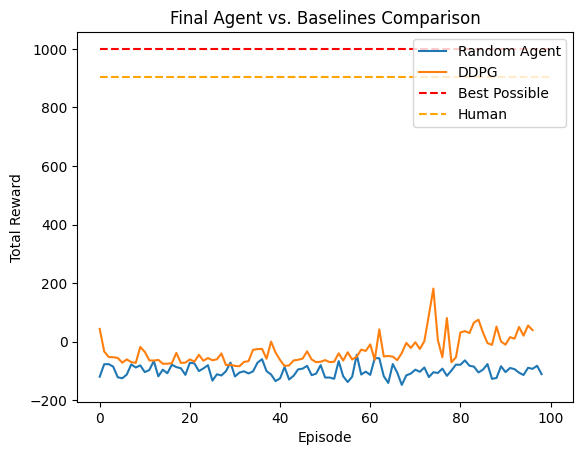

In [33]:
run_results = pd.read_csv("random_baseline_carracing").to_numpy().squeeze()
ddpg_results = pd.read_csv("ddpg_results.txt").to_numpy().squeeze()

# plot loaded file results
plt.plot(run_results, label='Random Agent')
plt.plot(ddpg_results, label='DDPG')

# plot static y-lines
plt.hlines(1000, 0, 100, linestyles='dashed', label='Best Possible', colors='red')
plt.hlines(903, 0, 100, linestyles='dashed', label='Human', colors='orange')
plt.legend()

plt.title("Final Agent vs. Baselines Comparison"), plt.xlabel("Episode"), plt.ylabel("Total Reward")
plt.show()